# Proyek Akhir: Menyelesaikan Permasalahan Human Resource Perusahaan Jaya Jaya Maju

- Nama: Dewi Yuliana
- Email: dewiyulianaa938@gmail.com
- Id Dicoding: dewiyulianaa1507

## Persiapan

### Menyiapkan library yang dibutuhkan

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
import joblib
from sqlalchemy import create_engine

### Menyiapkan data yang akan diguankan

## Data Understanding

In [73]:
# Menyiapkan data
file_path = 'https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/refs/heads/main/employee/employee_data.csv'
employee = pd.read_csv(file_path)

In [74]:
# Menampilkan informasi awal tentang data
print("Shape:", employee.shape)

Shape: (1470, 35)


In [75]:
print("\nInfo:")
print(employee.info())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1470 non-null   int64  
 1   Age                       1470 non-null   int64  
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1470 non-null   object 
 4   DailyRate                 1470 non-null   int64  
 5   Department                1470 non-null   object 
 6   DistanceFromHome          1470 non-null   int64  
 7   Education                 1470 non-null   int64  
 8   EducationField            1470 non-null   object 
 9   EmployeeCount             1470 non-null   int64  
 10  EnvironmentSatisfaction   1470 non-null   int64  
 11  Gender                    1470 non-null   object 
 12  HourlyRate                1470 non-null   int64  
 13  JobInvolvement            1470 non-null   int64  
 14  J

In [76]:
#check missing values
print("\nMissing values per column:")
print(employee.isnull().sum())


Missing values per column:
EmployeeId                    0
Age                           0
Attrition                   412
BusinessTravel                0
DailyRate                     0
Department                    0
DistanceFromHome              0
Education                     0
EducationField                0
EmployeeCount                 0
EnvironmentSatisfaction       0
Gender                        0
HourlyRate                    0
JobInvolvement                0
JobLevel                      0
JobRole                       0
JobSatisfaction               0
MaritalStatus                 0
MonthlyIncome                 0
MonthlyRate                   0
NumCompaniesWorked            0
Over18                        0
OverTime                      0
PercentSalaryHike             0
PerformanceRating             0
RelationshipSatisfaction      0
StandardHours                 0
StockOptionLevel              0
TotalWorkingYears             0
TrainingTimesLastYear         0
WorkLifeBala

In [77]:
#mendeskripsikan data statistic
print("\nDescriptive statistics:")
print(employee.describe())


Descriptive statistics:
        EmployeeId          Age    Attrition    DailyRate  DistanceFromHome  \
count  1470.000000  1470.000000  1058.000000  1470.000000       1470.000000   
mean    735.500000    36.923810     0.169187   802.485714          9.192517   
std     424.496761     9.135373     0.375094   403.509100          8.106864   
min       1.000000    18.000000     0.000000   102.000000          1.000000   
25%     368.250000    30.000000     0.000000   465.000000          2.000000   
50%     735.500000    36.000000     0.000000   802.000000          7.000000   
75%    1102.750000    43.000000     0.000000  1157.000000         14.000000   
max    1470.000000    60.000000     1.000000  1499.000000         29.000000   

         Education  EmployeeCount  EnvironmentSatisfaction   HourlyRate  \
count  1470.000000         1470.0              1470.000000  1470.000000   
mean      2.912925            1.0                 2.721769    65.891156   
std       1.024165            0.0     

<Figure size 1200x800 with 0 Axes>

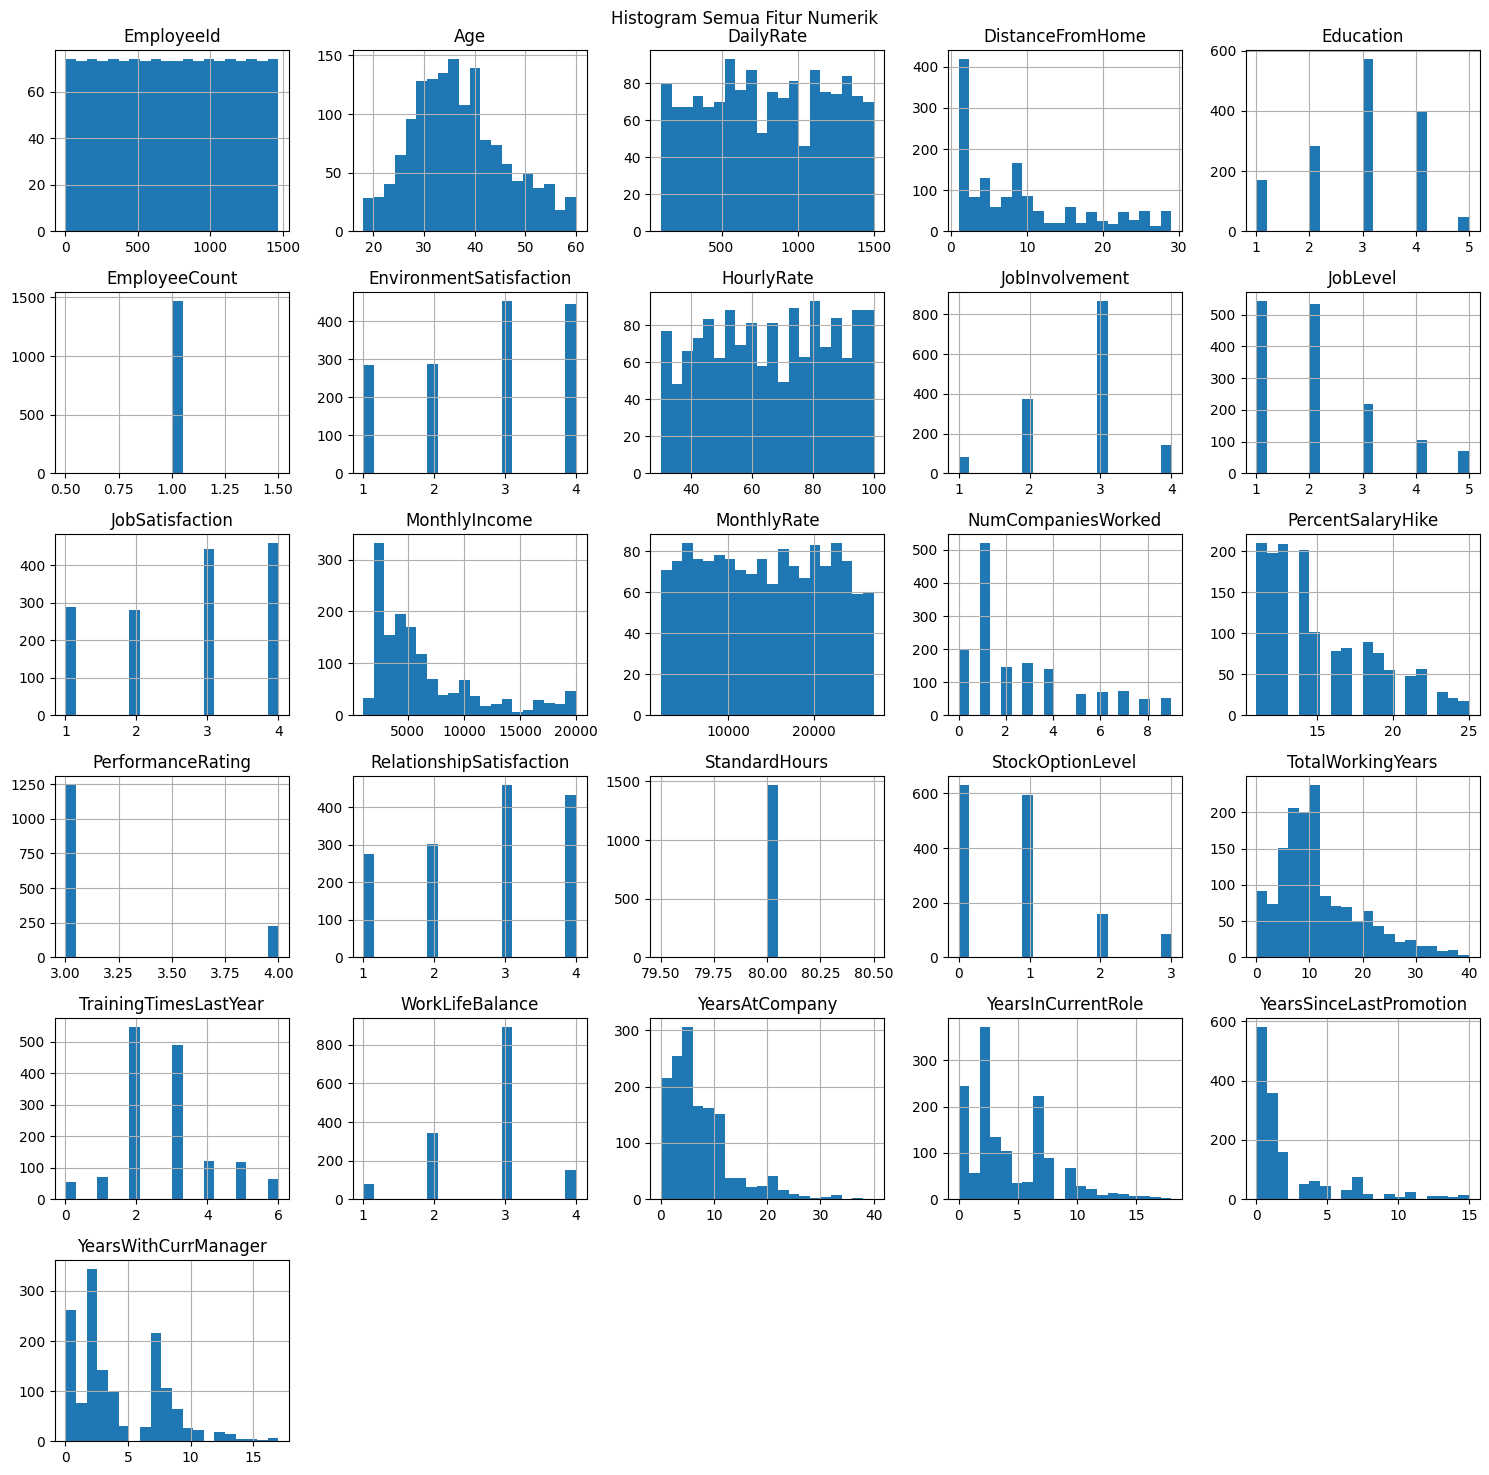

In [78]:
# Distribusi data numerik
numeric_cols = employee.select_dtypes(include=[np.number]).columns.drop('Attrition')
plt.figure(figsize=(12, 8))
employee[numeric_cols].hist(bins=20, layout=(6, 5), figsize=(15,15))
plt.suptitle("Histogram Semua Fitur Numerik")
plt.tight_layout()
plt.show()

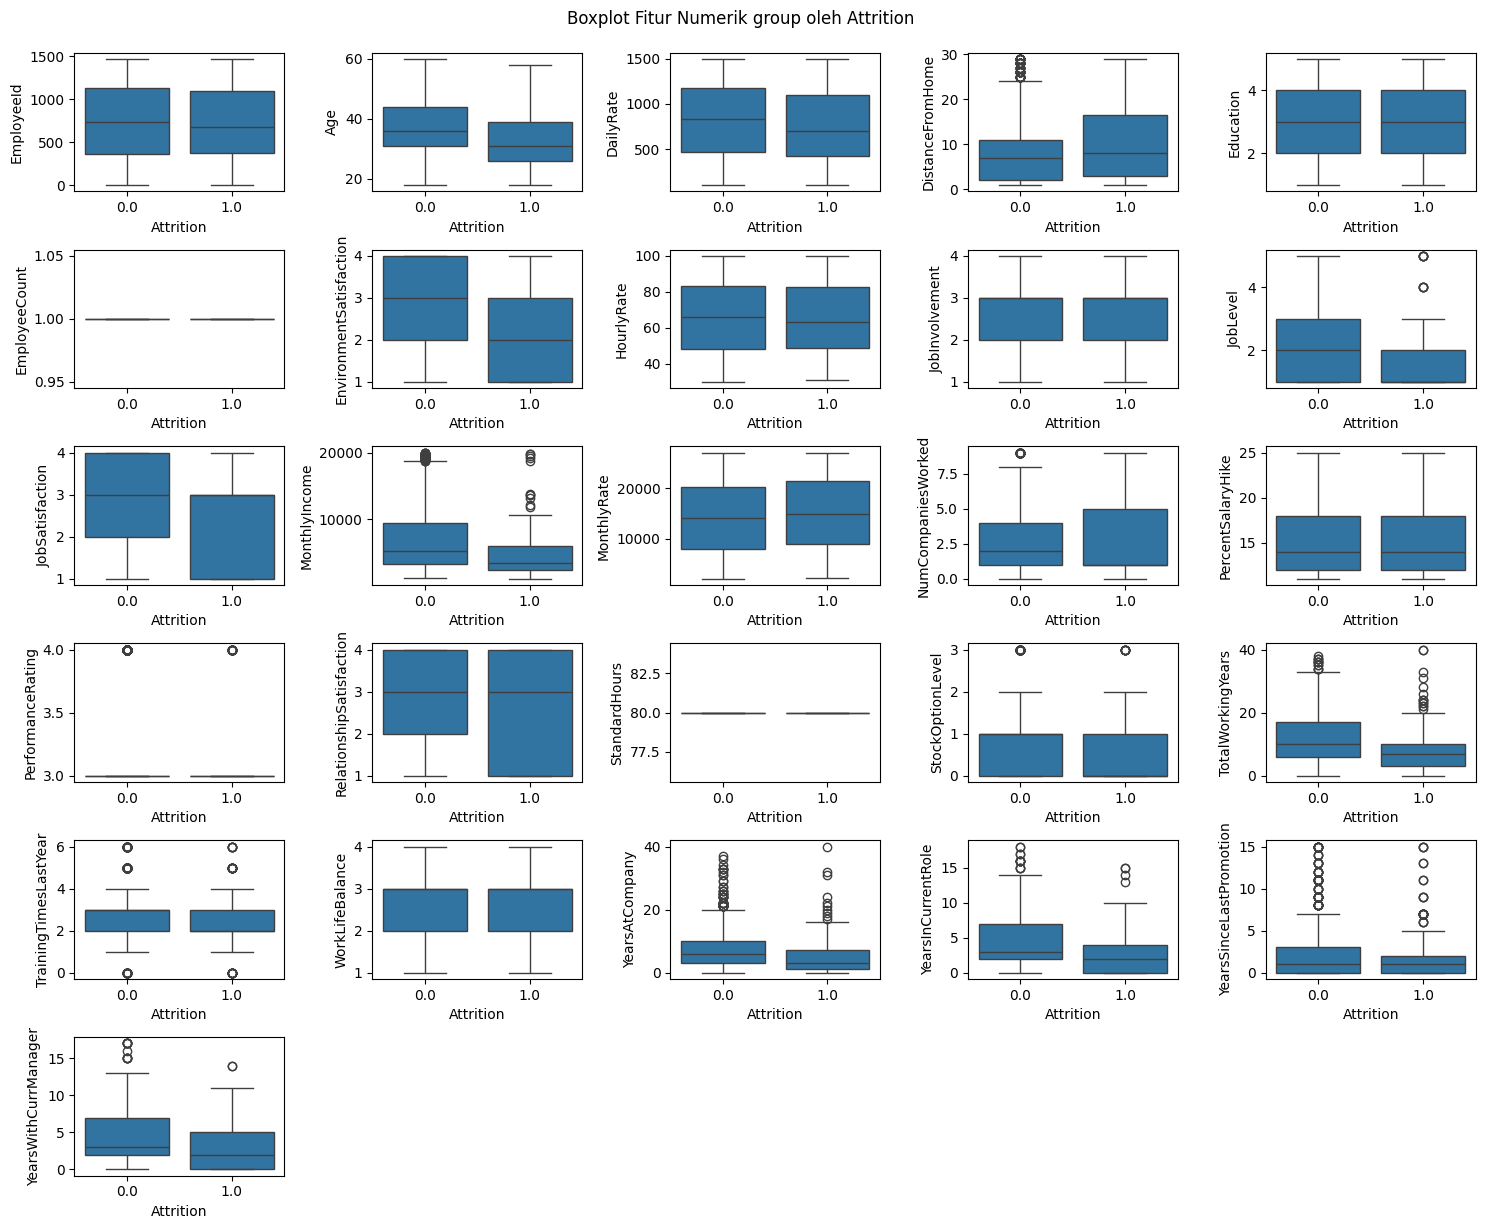

In [79]:
# Boxplot numeric vs Attrition
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(6, 5, i)
    sns.boxplot(x='Attrition', y=col, data=employee)
    plt.tight_layout()
plt.suptitle("Boxplot Fitur Numerik group oleh Attrition", y=1.02)
plt.show()

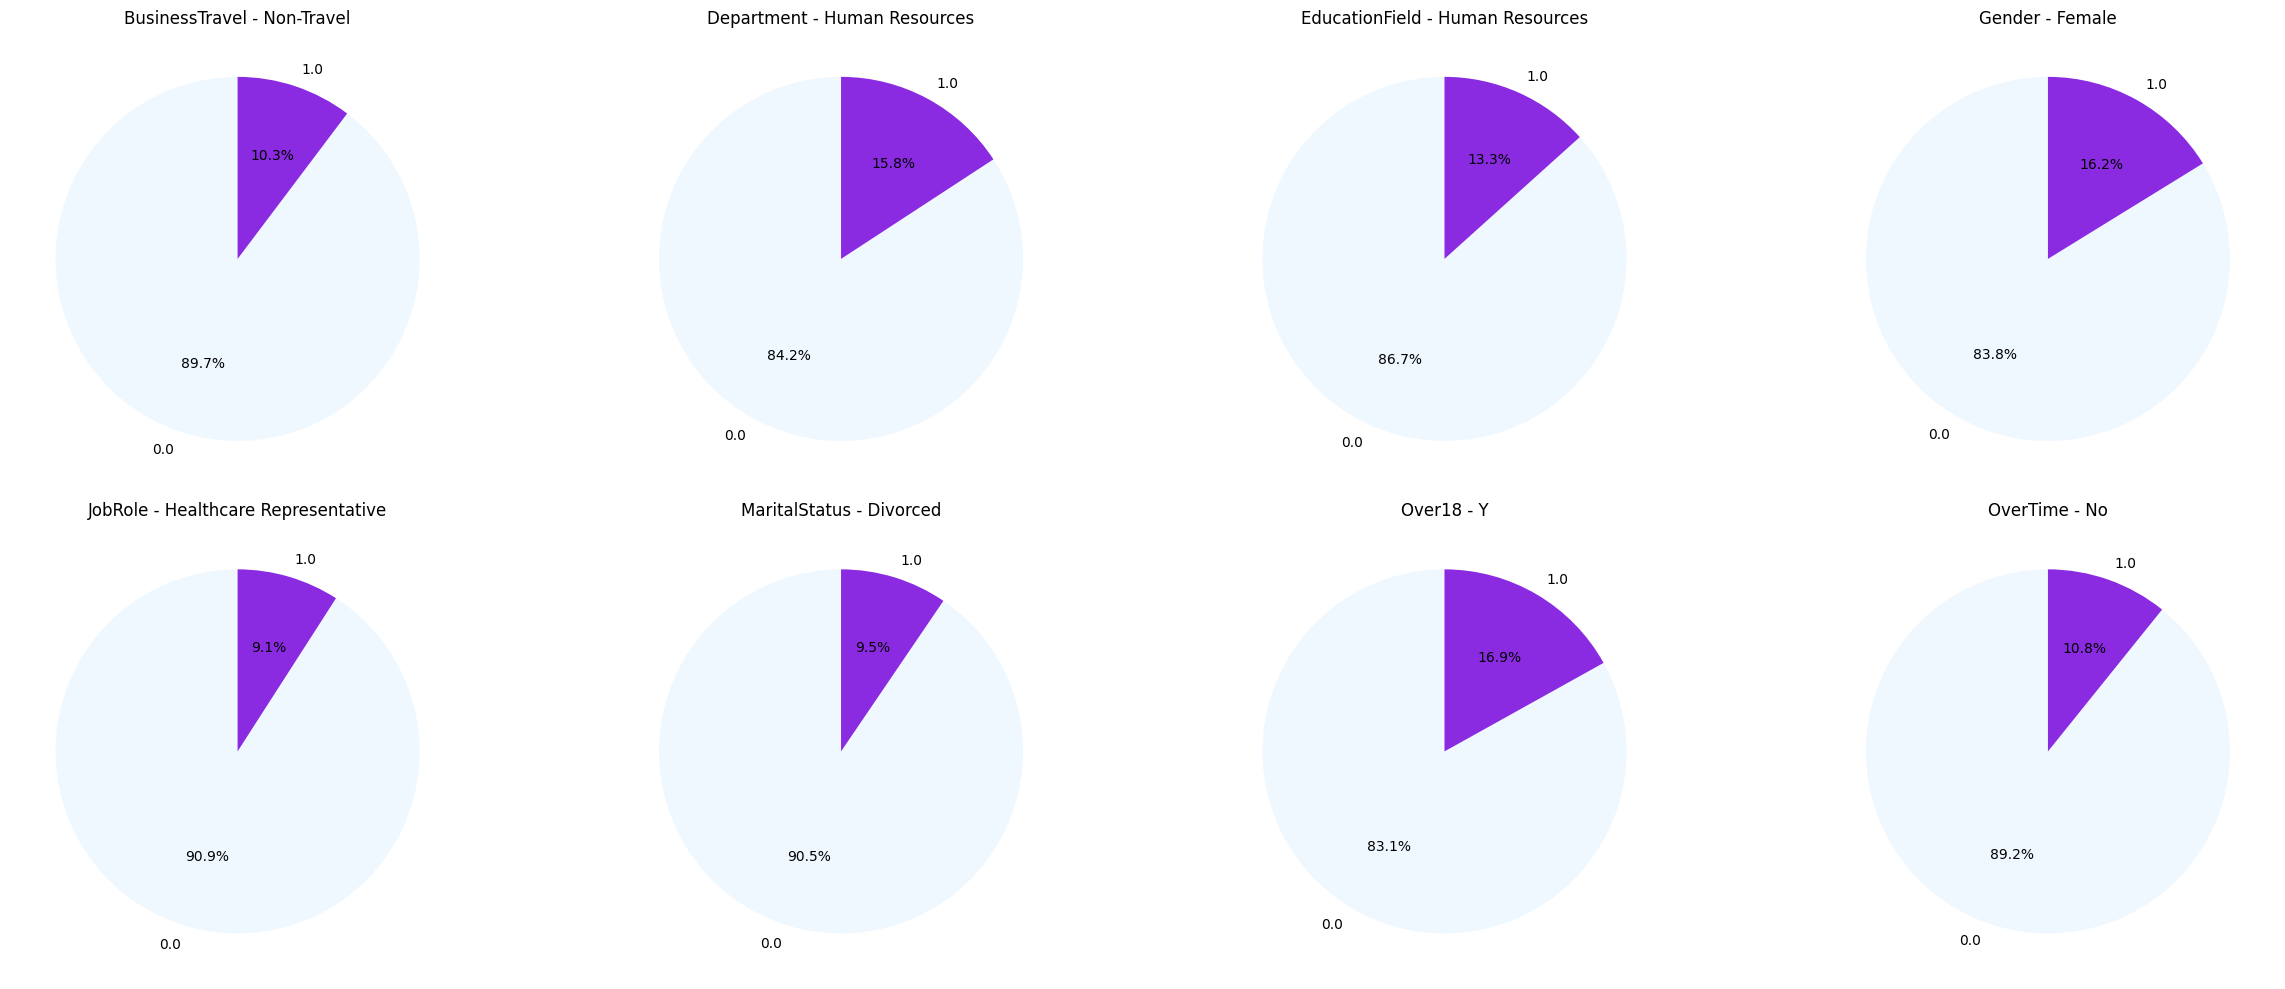

In [80]:
# Ambil kolom kategorikal dan target
categorical_cols = employee.select_dtypes(include=['object']).columns
plots_per_row = 4
rows = (len(categorical_cols) + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(rows, plots_per_row, figsize=(25, rows * 5))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # Crosstab proporsi berdasarkan Attrition
    prop = pd.crosstab(employee[col], employee['Attrition'], normalize='index') * 100

    # Warna untuk konsistensi
    colors = ['#F0F8FF', '#8A2BE2']

    # Pie per kategori dalam kolom
    for j, category in enumerate(prop.index):
        axes[i].pie(
            prop.loc[category],
            labels=prop.columns,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors
        )
        axes[i].set_title(f"{col} - {category}")
        break  # tampilkan satu contoh kategori saja agar layout rapi

# Nonaktifkan sumbu kosong
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


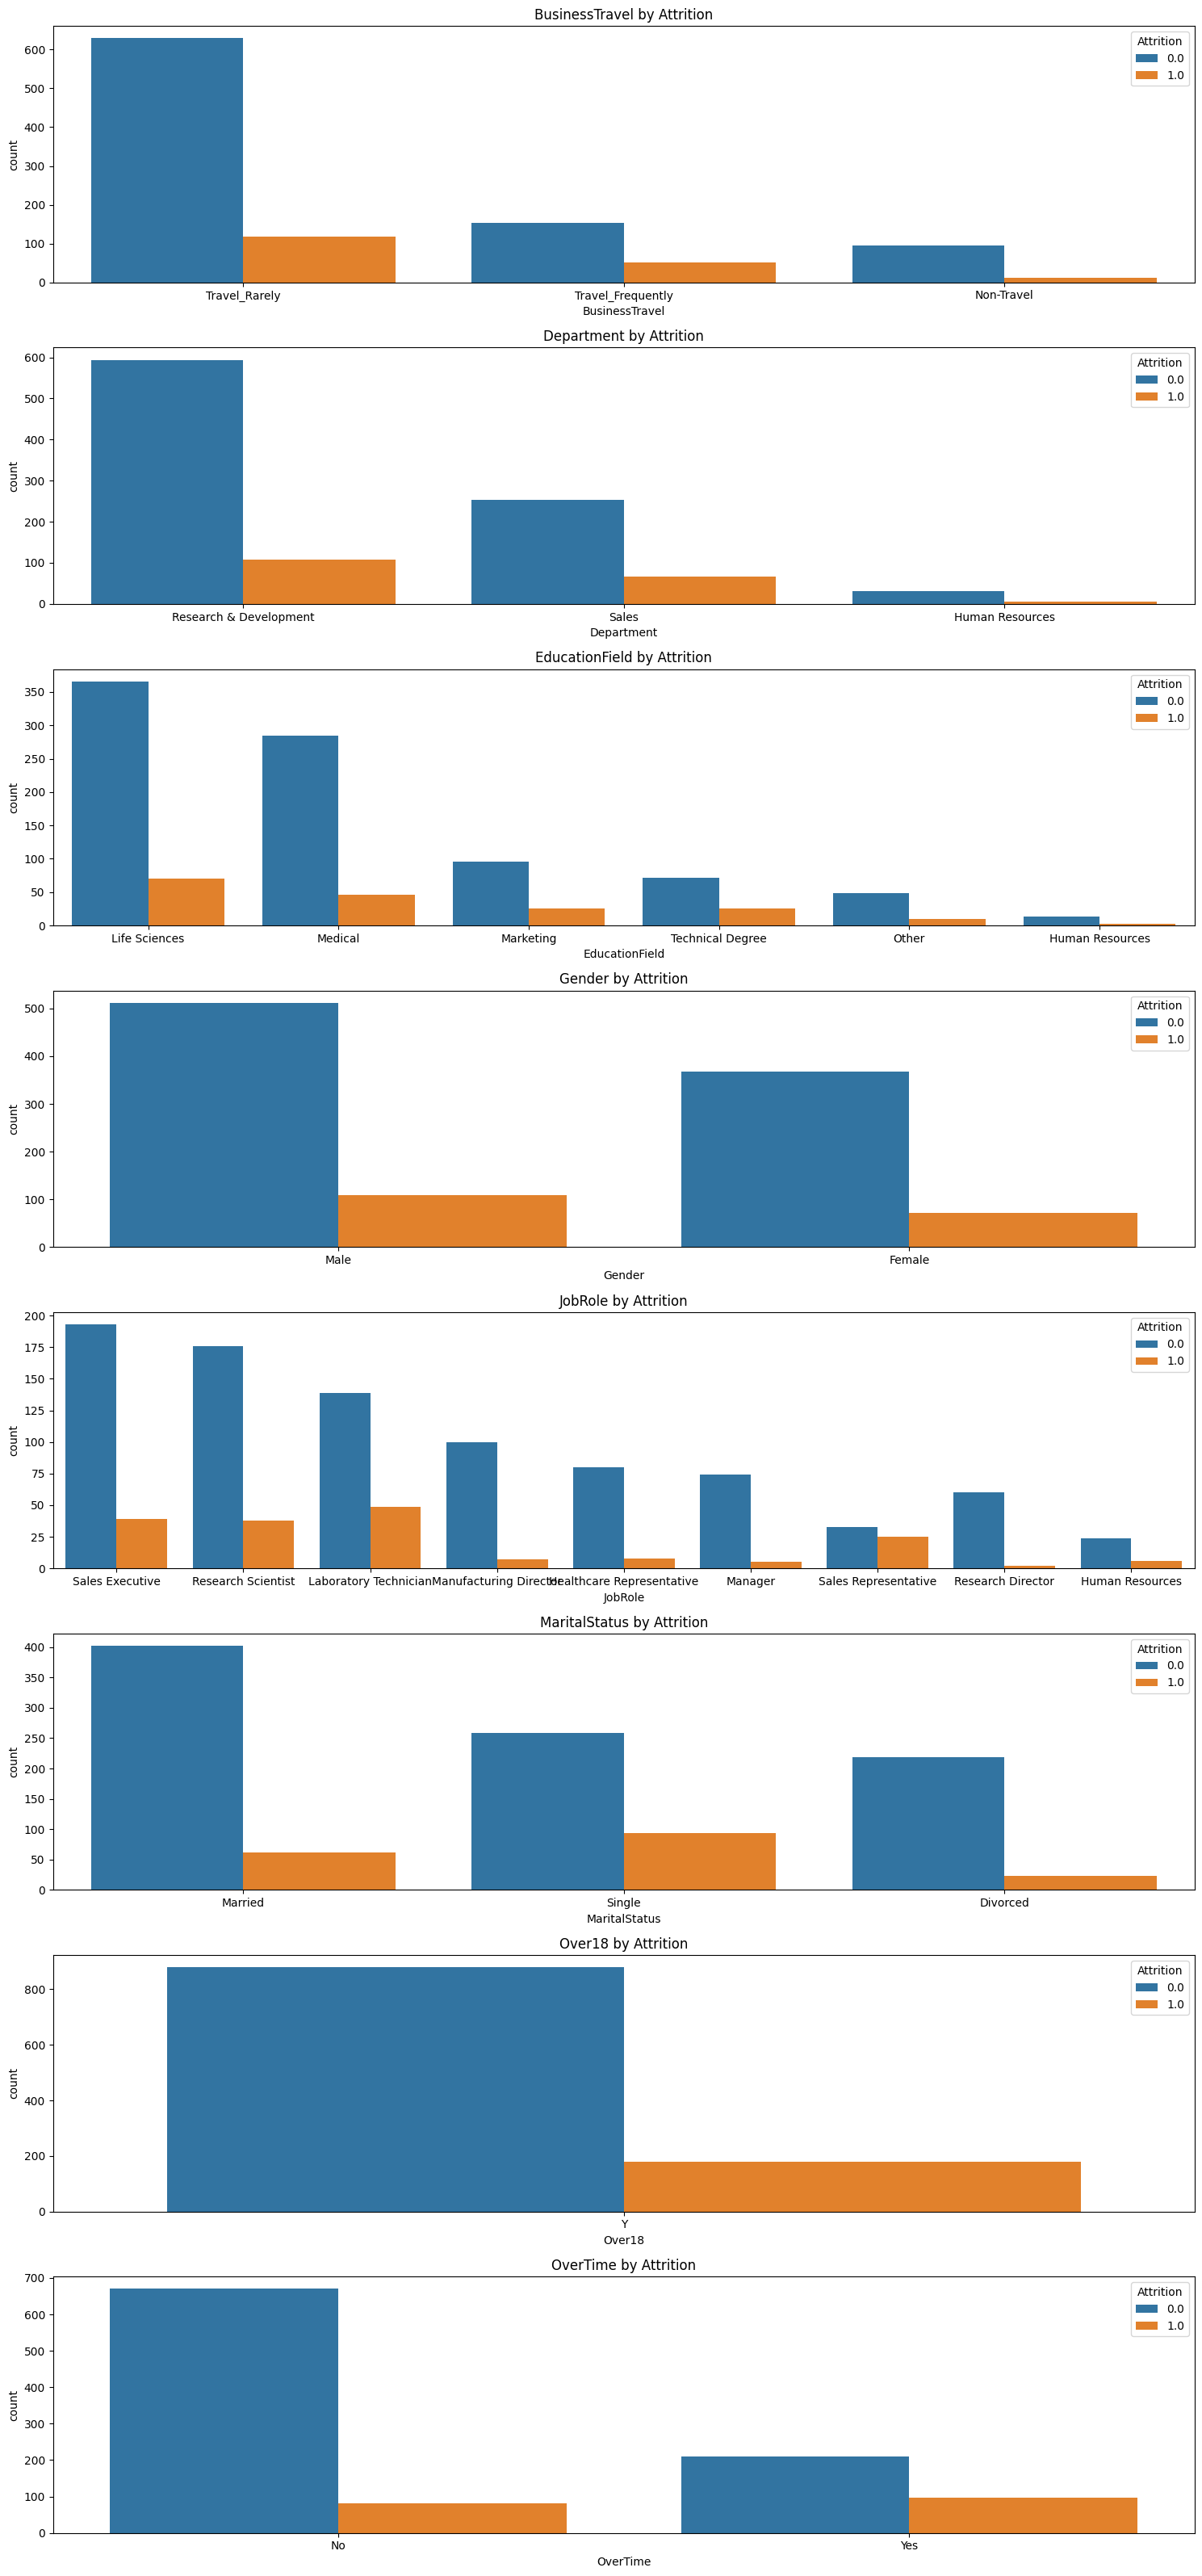

In [81]:
# Barplot count dan % Attrition per kategori
categorical_cols = employee.select_dtypes(include=['object']).columns
plt.figure(figsize=(15, len(categorical_cols)*4))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 1, i)
    order = employee[col].value_counts().index
    sns.countplot(x=col, hue='Attrition', data=employee, order=order)
    plt.title(f"{col} by Attrition")
    plt.legend(title='Attrition')
    plt.tight_layout()
plt.show()

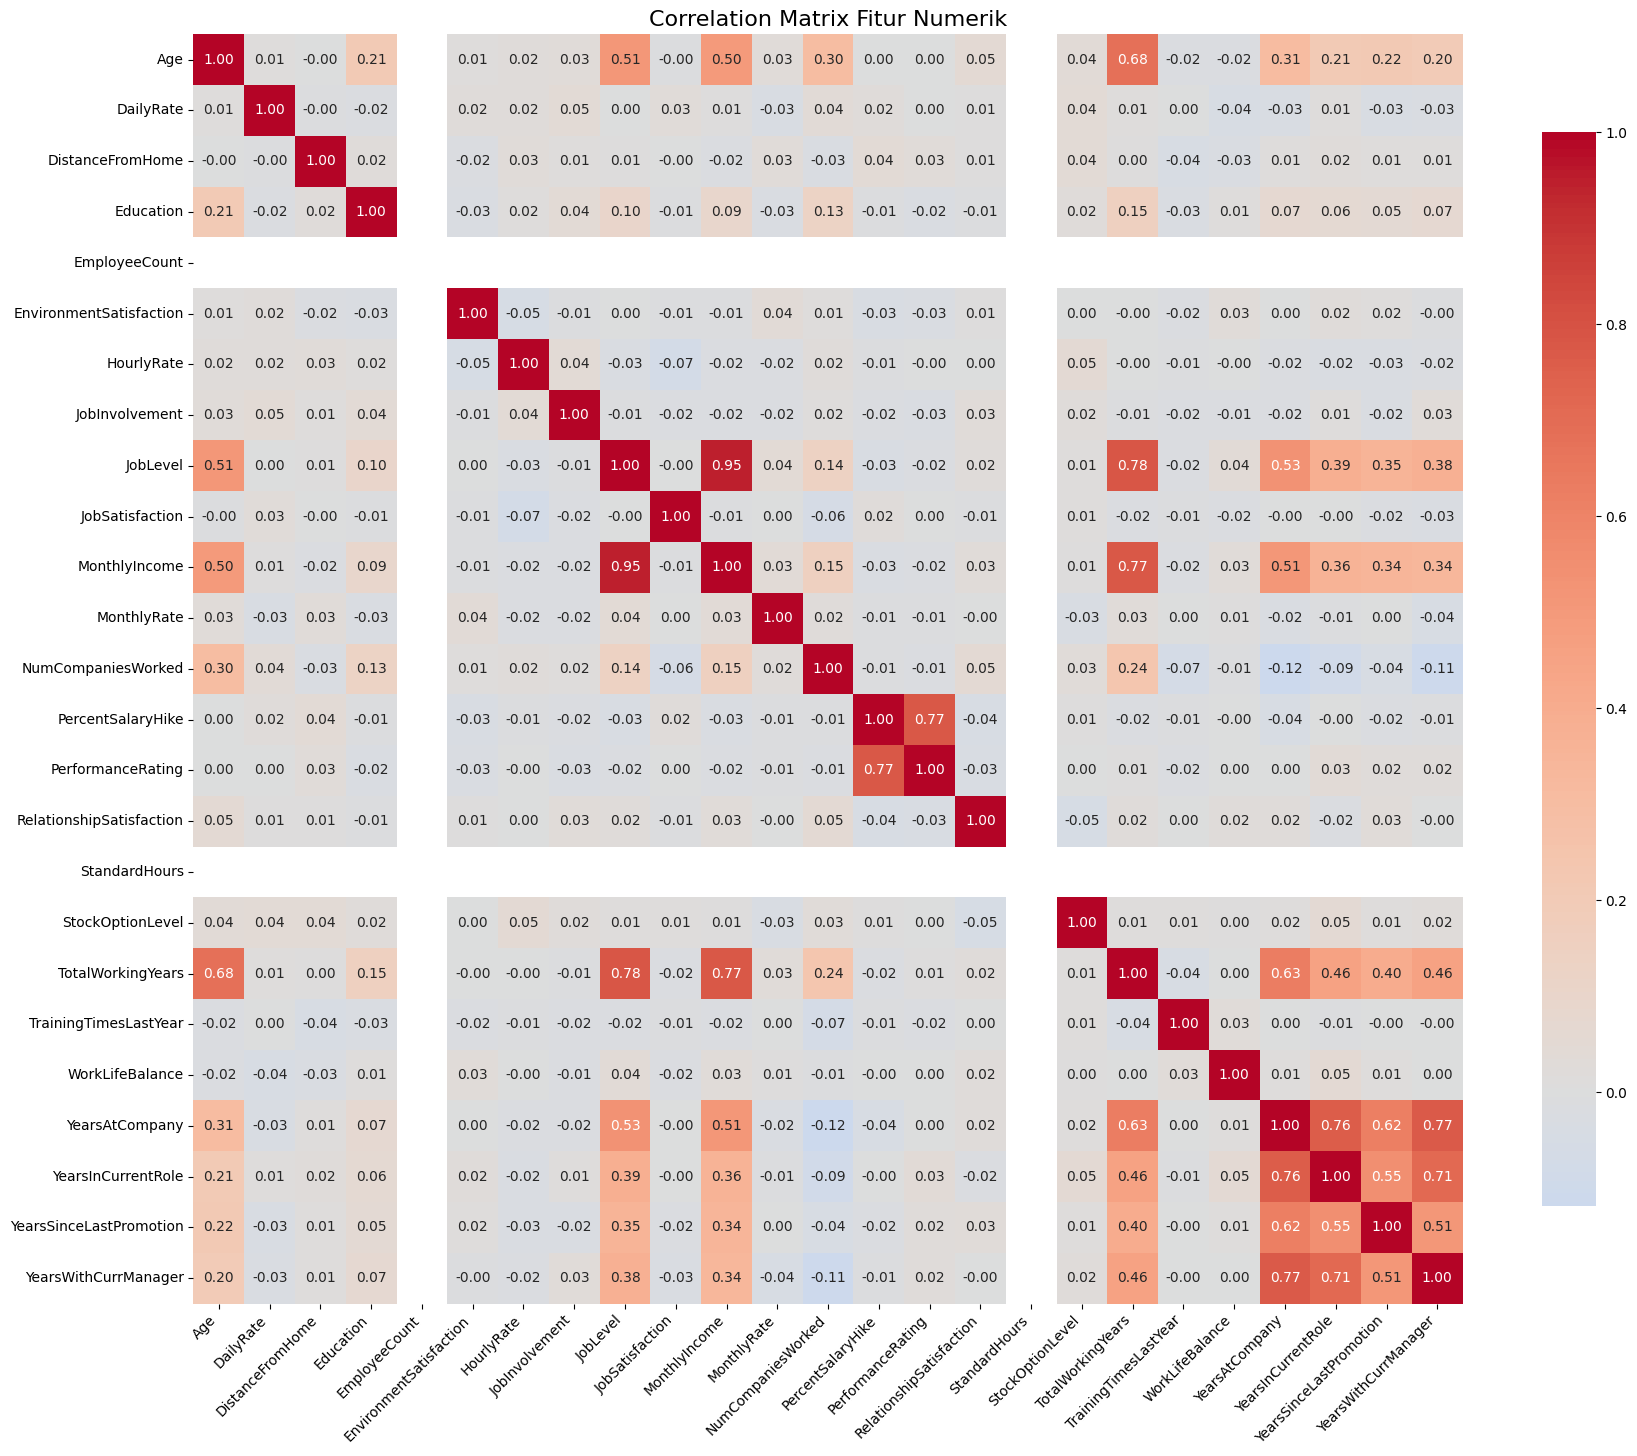

In [82]:
# Korelasi numerik dengan angka
numeric_cols = employee.select_dtypes(include=[np.number]).columns.drop(['Attrition', 'EmployeeId'])
corr = employee[numeric_cols].corr()

plt.figure(figsize=(18, 15))
sns.heatmap(
    corr,
    annot=True,             # Menampilkan angka korelasi
    fmt=".2f",              # Format angka dua desimal
    cmap='coolwarm',
    center=0,
    square=True,            # Membuat kotak korelasi simetris
    cbar_kws={"shrink": 0.8}  # Mengecilkan color bar
)
plt.title("Correlation Matrix Fitur Numerik", fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotasi label sumbu x
plt.yticks(rotation=0)               # Rotasi label sumbu y
plt.tight_layout()
plt.show()


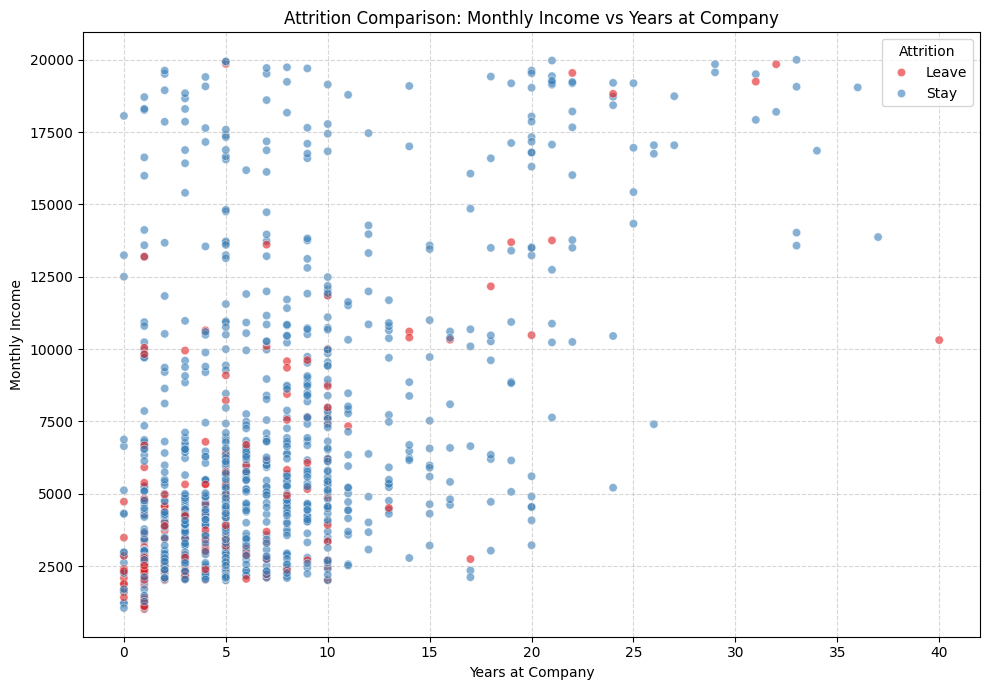

In [83]:
# Mapping label attrition
employee['AttritionLabel'] = employee['Attrition'].map({0: 'Stay', 1: 'Leave'})

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=employee,
    x='YearsAtCompany',
    y='MonthlyIncome',
    hue='AttritionLabel',
    palette=sns.color_palette("Set1"),
    alpha=0.6
)

plt.title("Attrition Comparison: Monthly Income vs Years at Company")
plt.xlabel("Years at Company")
plt.ylabel("Monthly Income")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Attrition")
plt.tight_layout()
plt.show()


## Data Preparation / Preprocessing

In [84]:
# Buat df_clean copy eksplisit
df_clean = employee.dropna(subset=['Attrition']).copy()

In [85]:
# Tentukan kolom
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.drop(['Attrition','EmployeeId'])
categorical_nominal = ['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus','Over18','OverTime']
categorical_ordinal = ['Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction',
               'PerformanceRating','RelationshipSatisfaction','WorkLifeBalance']

In [86]:
# Pipelines
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
nominal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])
ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
      ('num', num_pipe, numeric_cols),
      ('nom', nominal_pipe, categorical_nominal),
      ('ord', ordinal_pipe, categorical_ordinal)
    ],
    remainder='drop'    # semua kolom di luar num_cols+cat_nominal+cat_ordinal akan di-drop
)


In [87]:
# Terapkan preprocessing dan SMOTE dalam pipeline
pipeline = ImbPipeline([
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])

In [88]:
all_features = numeric_cols.tolist() + categorical_nominal + categorical_ordinal
all_features = list(dict.fromkeys(all_features))

In [105]:
# Split dan fit
X = df_clean[all_features]
y = df_clean['Attrition']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Modeling

In [90]:
# Definisikan 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [92]:

# Pipeline dengan XGBoost
pipe_xgb = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                          scale_pos_weight=1, # ganti jika imbalance
                          random_state=42))
])

# Pipeline dengan Random Forest tetap
pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

# Evaluasi Cross-Validation
for name, pipe in [('XGBoost', pipe_xgb), ('RandomForest', pipe_rf)]:
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc')
    print(f"{name} ROC AUC CV: {scores.mean():.3f} ± {scores.std():.3f}")


XGBoost ROC AUC CV: 0.779 ± 0.026
RandomForest ROC AUC CV: 0.788 ± 0.033


In [93]:
#Hyperparameter tuning dengan GridSearchCV
# Parameter grid untuk XGBoost
param_grid_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.1, 0.01],
    'clf__subsample': [0.8, 1.0]
}
   # untuk xgboost
gs_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_xgb.fit(X_train, y_train)
print("XGBoost Best Params:", gs_xgb.best_params_)
print("XGBoost Best CV ROC AUC:", gs_xgb.best_score_)

# untuk RandomForest
param_grid_rf = {
    'clf__n_estimators': [100,200],
    'clf__max_depth': [None, 5, 10]
}
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=cv, scoring='roc_auc', n_jobs=-1)
gs_rf.fit(X_train, y_train)
print("RF best params:", gs_rf.best_params_)
print("RF best CV ROC AUC:", gs_rf.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
XGBoost Best Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 0.8}
XGBoost Best CV ROC AUC: 0.799081857247668
RF best params: {'clf__max_depth': 10, 'clf__n_estimators': 100}
RF best CV ROC AUC: 0.7915767040491912


In [91]:
best_pipelines = {
    'XGBoost': gs_xgb.best_estimator_,
    'RandomForest': gs_rf.best_estimator_
}


In [94]:
from sklearn.metrics import roc_auc_score, classification_report

best_xgb = gs_xgb.best_estimator_
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print("ROC AUC (Test):", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


ROC AUC (Test): 0.8226010101010102
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92       176
         1.0       0.65      0.31      0.42        36

    accuracy                           0.85       212
   macro avg       0.76      0.64      0.67       212
weighted avg       0.83      0.85      0.83       212



## Evaluation

=== XGBoost ===
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92       176
         1.0       0.65      0.31      0.42        36

    accuracy                           0.85       212
   macro avg       0.76      0.64      0.67       212
weighted avg       0.83      0.85      0.83       212

ROC AUC: 0.8226010101010102


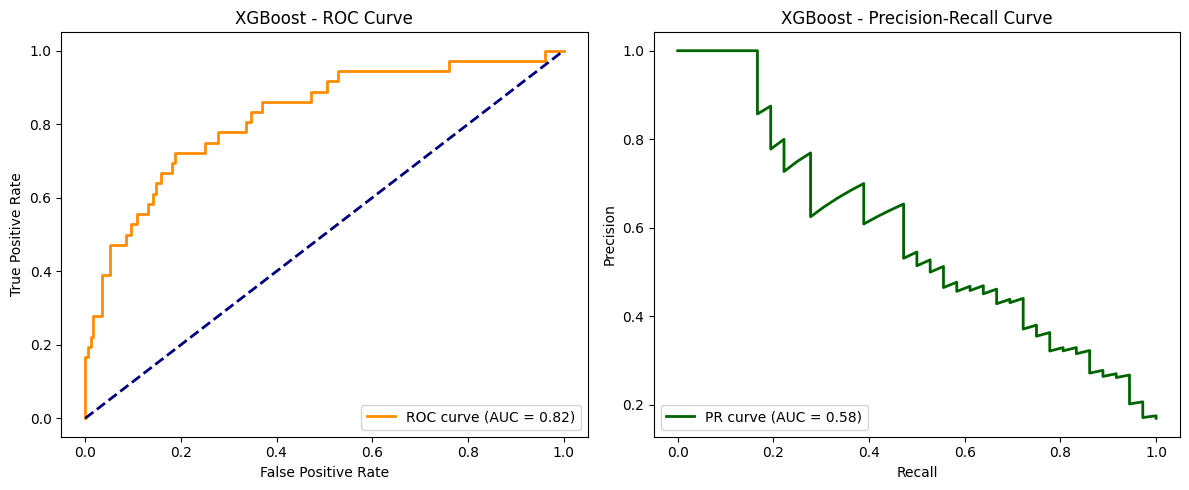

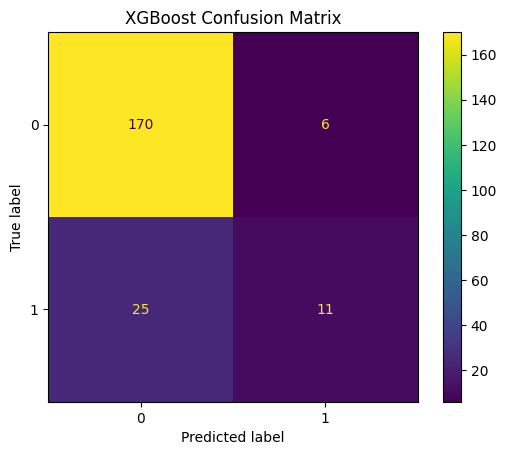

=== RandomForest ===
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.92       176
         1.0       0.82      0.25      0.38        36

    accuracy                           0.86       212
   macro avg       0.84      0.62      0.65       212
weighted avg       0.86      0.86      0.83       212

ROC AUC: 0.7902462121212123


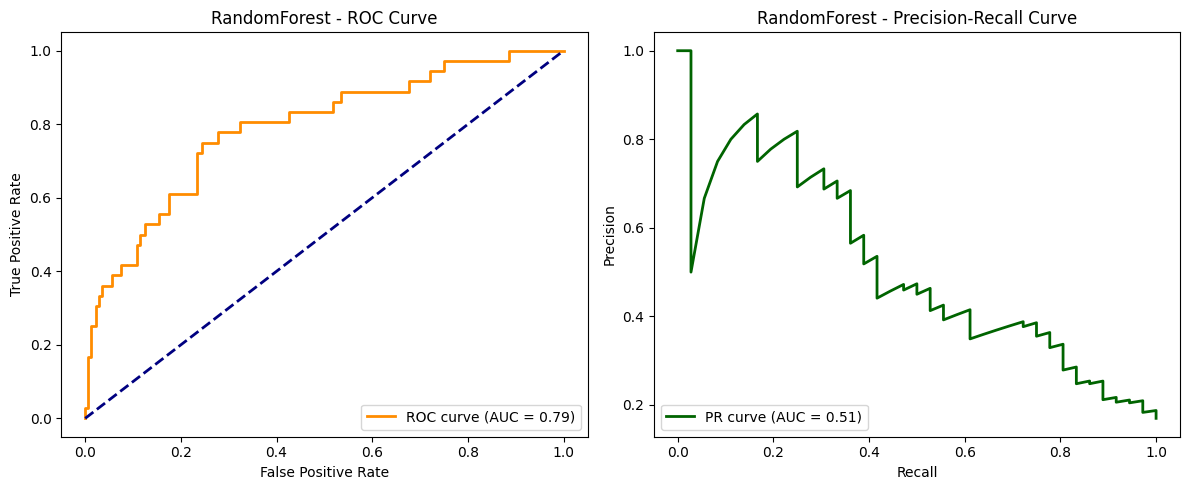

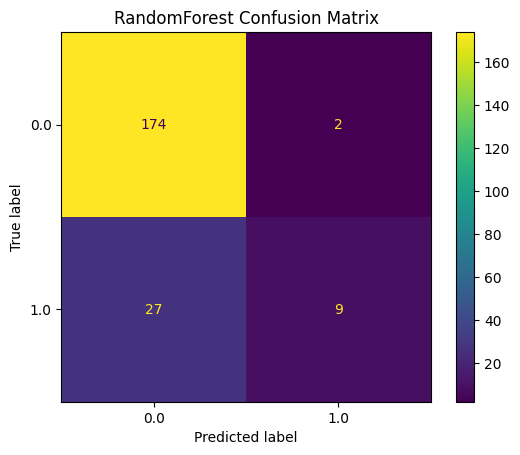

In [98]:
# Evaluasi pada test set: classification report, confusion matrix, curves

for name, pipe in best_pipelines.items():
    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    plot_curves(name, y_test, y_proba)

    # Visualisasi confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=pipe.classes_)
    disp.ax_.set_title(f"{name} Confusion Matrix")
    plt.show()


In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Accuracy: 0.8632075471698113
Precision: 0.8181818181818182
Recall: 0.25
F1 Score: 0.3829787234042553


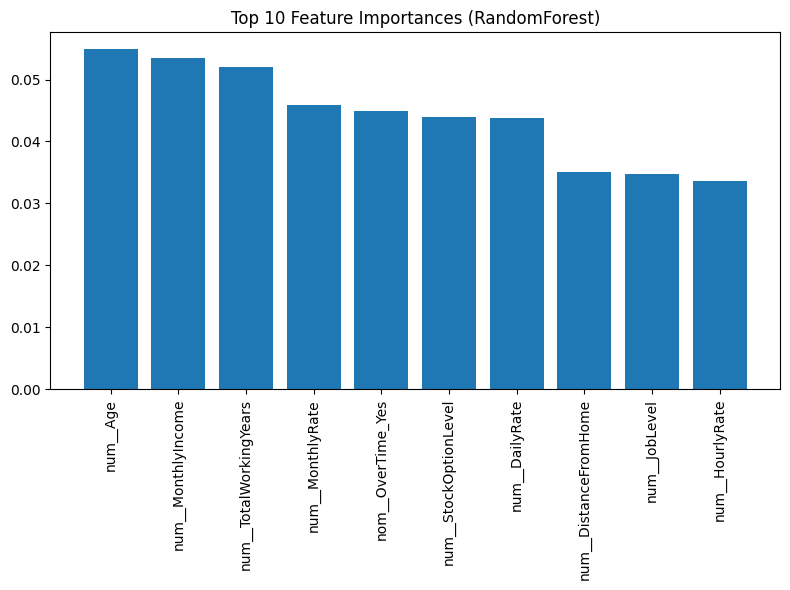

In [99]:
# Dapatkan nama fitur sesudah preprocessing
pre = best_pipelines['RandomForest'].named_steps['pre']
# untuk sklearn ≥1.0:
feat_names = pre.get_feature_names_out()

# 2. RandomForest — importances
rf_clf = best_pipelines['RandomForest'].named_steps['clf']
importances = rf_clf.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(8,6))
plt.bar(feat_names[indices][:10], importances[indices][:10])
plt.xticks(rotation=90)
plt.title('Top 10 Feature Importances (RandomForest)')
plt.tight_layout()
plt.show()

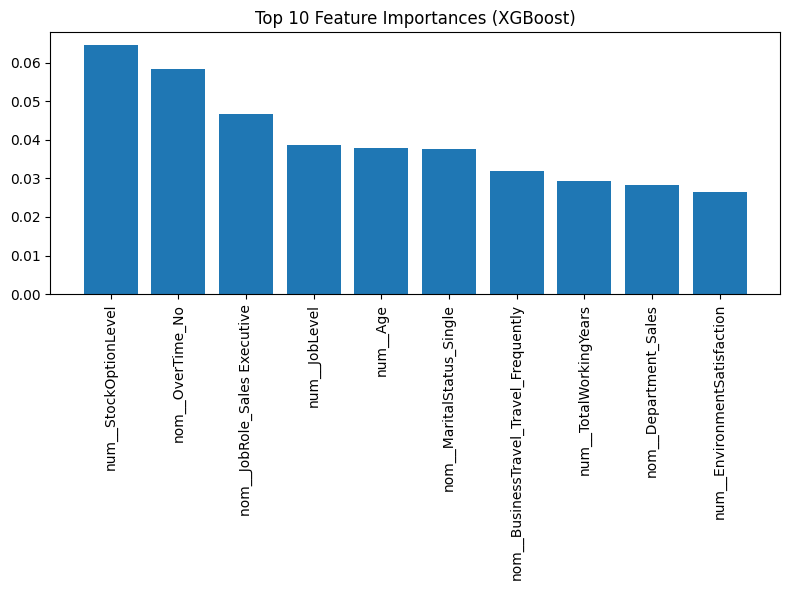

In [100]:
# Ambil model terbaik XGBoost dari pipeline
xgb_clf = best_pipelines['XGBoost'].named_steps['clf']

# Ambil feature names dari preprocessing pipeline
# Misalnya: ColumnTransformer -> OneHotEncoder/numerical pipeline
feat_names = best_pipelines['XGBoost'].named_steps['pre'].get_feature_names_out()

# Ambil feature importance
importances = xgb_clf.feature_importances_
indices = importances.argsort()[::-1]

# Plot 10 feature paling penting
plt.figure(figsize=(8,6))
plt.bar(feat_names[indices][:10], importances[indices][:10])
plt.xticks(rotation=90)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


In [101]:
# Simpan model terbaik
joblib.dump(gs_xgb.best_estimator_, 'best_pipeline.pkl')

['best_pipeline.pkl']

In [107]:
# Tambahkan prediksi dan probabilitas ke dataframe
df_score = df_clean.copy()
df_score['Prediction'] = best_xgb.predict(X)
df_score['Prob_Leave'] = best_xgb.predict_proba(X)[:, 1]

# Simpan ke file CSV untuk upload manual ke Looker Studio
df_score.to_csv('employee_scored.csv', index=False)

print("✅ Data siap dipakai di Looker Studio: employee_scored.csv")


✅ Data siap dipakai di Looker Studio: employee_scored.csv
